In [46]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from c_Population_graph.community_detection import detect_communities
from survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test

In [47]:
iteration = 2
PhenoGraph_k =  100
size_smallest_cluster = 20

In [48]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)


In [38]:
PopulationGraph_type = 'complete_graph_with_weak_edges_removed'
para_dict = {
    'weight_threshold_percentile': 50,
}
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)
Community_ids = detect_communities(G_population, size_smallest_cluster)

### Calculate hazard

In [39]:
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
clinical['Relapse Free Status Status'] = clinical['Relapse Free Status'].map({'0:Not Recurred':0, '1:Recurred':1})
clinical['Disease-specific Survival Status'] = clinical['Disease-specific Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
Length_OS = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs]
Status_OS = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival Status'].values[0] for i in Patient_IDs]
Length_RFS = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status (Months)'].values[0] for i in Patient_IDs]
Status_RFS = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status'].values[0] for i in Patient_IDs]
Length_DSS = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival (Months)'].values[0] for i in Patient_IDs]
Status_DSS = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival Status'].values[0] for i in Patient_IDs]
HR_OS = calculate_hazard_ratio(Length_OS, Length_OS, Community_ids)
HR_RFS = calculate_hazard_ratio(Length_RFS, Length_RFS, Community_ids)
HR_DSS = calculate_hazard_ratio(Length_DSS, Length_DSS, Community_ids)
for i in range(len(HR_OS)):
    print("Community {}:".format(i+1))
    print("Overall survival: hr = {}, p = {}".format(HR_OS[i]['hr'], HR_OS[i]['p']))
    print("Relapse free survival: hr = {}, p = {}".format(HR_RFS[i]['hr'], HR_RFS[i]['p']))
    print("Disease-specific survival: hr = {}, p = {}".format(HR_DSS[i]['hr'], HR_DSS[i]['p']))

Community 1:
Overall survival: hr = 1.1714501064219227, p = 0.17030912686815813
Relapse free survival: hr = 1.1532837948092662, p = 0.21803584077462188
Disease-specific survival: hr = 1.1297332392070318, p = 0.25760684680798096
Community 2:
Overall survival: hr = 0.8148961770304981, p = 0.105190162568615
Relapse free survival: hr = 0.9579827127789143, p = 0.7315676027486688
Disease-specific survival: hr = 0.8517692845675121, p = 0.1714440089538841
Community 3:
Overall survival: hr = 0.8272419536631732, p = 0.1442602643366891
Relapse free survival: hr = 0.7612201169196416, p = 0.03554206365264364
Disease-specific survival: hr = 0.8329843761548444, p = 0.1268731544025327
Community 4:
Overall survival: hr = 1.1058602538647162, p = 0.4954061415856592
Relapse free survival: hr = 0.9419778243970092, p = 0.6879941409227226
Disease-specific survival: hr = 1.0325220866964433, p = 0.8185734208788927
Community 5:
Overall survival: hr = 1.1888794603051744, p = 0.27862481339177025
Relapse free surv

### Reorder Communities based on Hazard

In [40]:
HR = HR_DSS
Length = Length_DSS
Status = Status_DSS
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids = np.zeros_like(Community_ids)
for i in range(len(HR)):
    Subgroup_ids[Community_ids == HR[i]['community_id']] = i+1
    HR[i]['subgroup_id'] = i+1

### Plot hazard

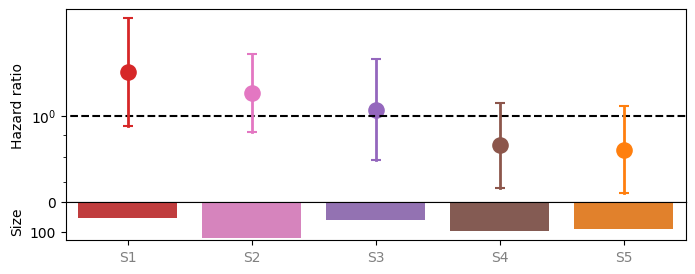

In [41]:
# Plot hazard ratio
color_palette = [
    sns.color_palette("tab10")[3],
    sns.color_palette("tab10")[6],
    sns.color_palette("tab10")[4],
    sns.color_palette("tab10")[5],
    sns.color_palette("tab10")[1],
    sns.color_palette("Set2")[-3],
    sns.color_palette("tab10")[-1],
    sns.color_palette("tab10")[0],
    sns.color_palette("tab10")[2],
]
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []

unique_subgroup_ids = np.unique(Subgroup_ids)
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Subgroup_ids == subgroup_id))
    xticklabels.append("S{}".format(int(subgroup_id)))
    if p < 0.05:
        xtickcolors.append("k")
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

### Plot Survival

TypeError: NaNs were detected in the dataset. Try using pd.isnull to find the problematic values.

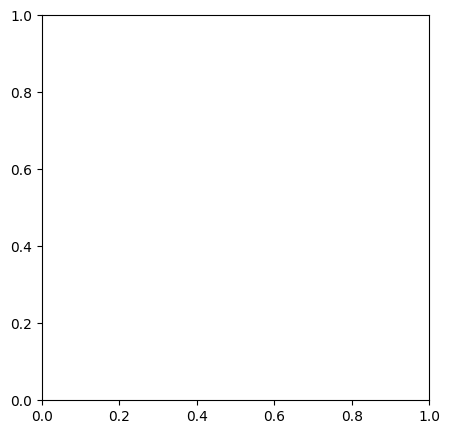

In [37]:
Length = np.array(Length)
Status = np.array(Status)
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for i, hr_dict in enumerate(HR):
    subgroup_id = hr_dict['subgroup_id']
    length_A, event_observed_A = (
            Length[Subgroup_ids == subgroup_id],
            Status[Subgroup_ids == subgroup_id],
        )
    label = "S{} (N={})".format(hr_dict["subgroup_id"], np.sum(Subgroup_ids == subgroup_id))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[i],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})
log_rank_test  = multivariate_logrank_test(
        Length[Subgroup_ids!=0], Subgroup_ids[Subgroup_ids!=0],Status[Subgroup_ids!=0]
    )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()